In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from astropy.table import Table, join
from astropy import units as u
import edge_pydb
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

## Plot CO observation parameters, a la Bolatto et al. (2017) Figure 4.  Note that the 'coobs' table is a simple CSV file, not ECSV.

In [2]:
coobs = Table.read(edge_pydb.getfiles('edge_coobs_de10.csv'), format='ascii.csv')

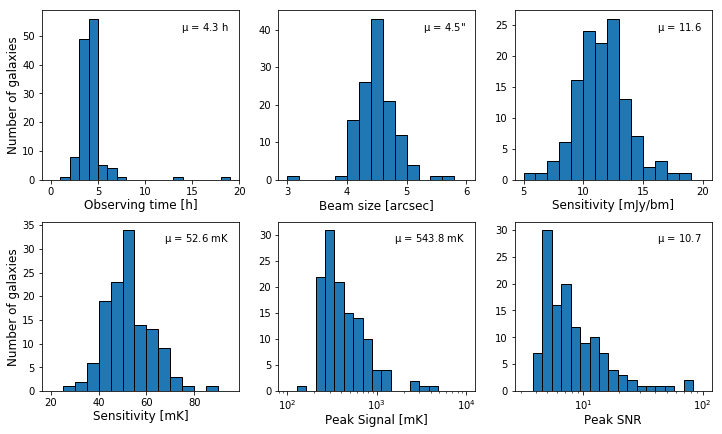

In [3]:
plt.figure(figsize=(12, 7))

ax1=plt.subplot(2,3,1)
plt.hist(coobs['coObstim'], bins=np.arange(0, 20, 1), ec='black')
plt.xlabel('Observing time [h]', labelpad=2, fontsize='large')
plt.ylabel('Number of galaxies', labelpad=2, fontsize='large')
ax1.text(0.95,0.88,'$\mu$ = %3.1f h' % np.mean(coobs['coObstim']),
    ha='right',transform=ax1.transAxes)

ax2=plt.subplot(2,3,2)
beam=np.sqrt(coobs['Bmaj']*coobs['Bmin'])
plt.hist(beam, bins=np.arange(3, 6.2, 0.2), ec='black')
plt.xlabel('Beam size [arcsec]', labelpad=2, fontsize='large')
tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.text(0.95,0.88,'$\mu$ = %3.1f"' % np.mean(beam),
    ha='right', transform=ax2.transAxes)

ax3=plt.subplot(2,3,3)
plt.hist(coobs['coRMS_mJybm'], bins=np.arange(5,21,1), ec='black')
plt.xlabel('Sensitivity [mJy/bm]', labelpad=2, fontsize='large')
ax3.text(0.95,0.88,'$\mu$ = %4.1f' % np.mean(coobs['coRMS_mJybm']),
    ha='right', transform=ax3.transAxes)

ax4=plt.subplot(2,3,4)
plt.hist(coobs['coRMS_mK'], bins=np.arange(20,100,5), ec='black')
plt.xlabel('Sensitivity [mK]', labelpad=2, fontsize='large')
plt.ylabel('Number of galaxies', labelpad=2, fontsize='large')
ax4.text(0.95,0.88,'$\mu$ = %4.1f mK' % np.mean(coobs['coRMS_mK']),
    ha='right', transform=ax4.transAxes)

ax5=plt.subplot(2,3,5)
plt.hist(coobs['coTpk_mK'], bins=np.logspace(2,4,num=20), ec='black')
plt.xlabel('Peak Signal [mK]', labelpad=2, fontsize='large')
ax5.set_xscale("log")
ax5.text(0.95,0.88,'$\mu$ = %4.1f mK' % np.mean(coobs['coTpk_mK']),
    ha='right', transform=ax5.transAxes)

ax6=plt.subplot(2,3,6)
plt.hist(coobs['coSNRpeak'], bins=np.logspace(0.5,2,num=20), ec='black')
plt.xlabel('Peak SNR', labelpad=2, fontsize='large')
ax6.set_xscale("log")
ax6.text(0.95,0.88,'$\mu$ = %4.1f' % np.mean(coobs['coSNRpeak']),
    ha='right', transform=ax6.transAxes)

plt.subplots_adjust(hspace=0.25)
plt.show()

## Derive $S_{CO}$ to $M_{mol}$ conversion.

In [4]:
# Calculate molecular mass for 1 Jy km/s at 1 Mpc.
# These serve as fiducial distance and flux which we will scale later.
sco  = 1 * u.Jy * u.km / u.s
dmpc = (1 * u.Mpc).to(u.pc)
alphaco = 4.3 * u.solMass * u.s / (u.K * u.km * u.pc**2) # Bolatto+13
freq = 115.271204 * u.GHz
kperjy = (1*u.Jy/u.sr).to(u.K, equivalencies=u.brightness_temperature(freq))
molmass = alphaco * kperjy * (sco/u.Jy) * dmpc**2
print(molmass)

10533.072545614323 solMass


## Plot derived CO masses, a la Bolatto et al. (2017) Figure 5.  Need to merge in two additional tables.

In [5]:
# Measured CO fluxes
coflux = Table.read(edge_pydb.getfiles('edge_coflux_natv.csv'), format='ascii.ecsv')  
# CALIFA params incl. distance
califa = Table.read(edge_pydb.getfiles('edge_califa.csv'), format='ascii.ecsv')  
db1 = join(coflux, califa, keys='Name')
db  = join(db1, coobs, keys='Name')

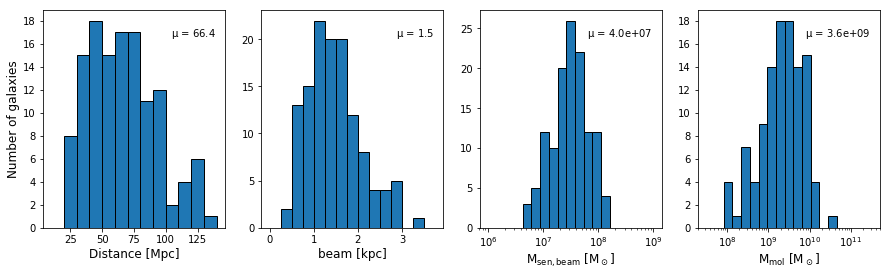

In [6]:
fig=plt.figure(figsize=(15, 4))

ax1=plt.subplot(1,4,1)
plt.hist(db['caDistMpc'],bins=np.arange(10, 150, 10), ec='black')
plt.xlabel('Distance [Mpc]', labelpad=3, fontsize='large')
plt.ylabel('Number of galaxies', labelpad=3, fontsize='large')
tick_spacing = 2
ax1.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.text(0.95,0.88,'$\mu$ = %3.1f' % np.mean(db['caDistMpc']),
    ha='right', transform=ax1.transAxes)

ax2=plt.subplot(1,4,2)
beam = (np.sqrt(db['coBmaj_natv']*db['coBmin_natv'])).to(u.rad)
bmkpc = beam.value*db['caDistMpc']*1000.
plt.hist(bmkpc,bins=np.arange(0, 4, 0.25), ec='black')
plt.xlabel('beam [kpc]', labelpad=3, fontsize='large')
ax2.text(0.95,0.88,'$\mu$ = %3.1f' % np.mean(bmkpc),
    ha='right', transform=ax2.transAxes)

ax3=plt.subplot(1,4,3)
# Multiply 10 km/s noise by sqrt(3) to get sensitivity to a 30 km/s line
# Multiply by 4 to get 4-sigma sensitivity
msens = 4*molmass*(db['caDistMpc']**2)*db['coRMS_mJybm']*10.*np.sqrt(3)/1000.
plt.hist(msens,bins=np.logspace(6, 9, num=20), ec='black')
plt.xlabel('$M_{sen,beam}$ [$M_\odot$]', labelpad=3, fontsize='large')
ax3.set_xscale("log")
ax3.text(0.95,0.88,'$\mu$ = %4.1e' % np.mean(msens.value),
    ha='right', transform=ax3.transAxes)

ax4=plt.subplot(1,4,4)
mgas = molmass*db['caDistMpc']**2*db['coSmooth_natv']
mgas = mgas[~np.isnan(mgas)]
plt.hist(mgas,bins=np.logspace(7.5, 11.5, num=20), ec='black')
plt.xlabel('$M_{mol}$ [$M_\odot$]', labelpad=3, fontsize='large')
ax4.set_xscale("log")
ax4.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax4.text(0.95,0.88,'$\mu$ = %4.1e' % np.mean(mgas.value),
    ha='right', transform=ax4.transAxes)

plt.show()

## Make scatterplots related to star-forming main sequence

In [7]:
print(califa.colnames)

['Name', 'caMass', 'caeMass', 'caSFR', 'caeSFR', 'caOH', 'caeOH', 'caAvgas', 'caeAvgas', 'caAvstars', 'caeAvstars', 'Su', 'Sg', 'Sr', 'Si', 'caB', 'caV', 'caR', 'caRe', 'caeRe', 'caEllipticity', 'caPA', 'caR50', 'caeR50', 'caR90', 'caeR90', 'caOH_O3N2', 'caZgas', 'caZstars', 'caAge', 'caeAge', 'caFHa', 'caFHacorr', 'caLHacorr', 'caMstars', 'caDistMpc', 'caFlgWav5', 'caFlgReg5', 'caFlgImg5', 'caFlgWav12', 'caFlgReg12', 'caFlgImg12']


dex(solMass) dex(solMass / yr)


Text(0, 0.5, 'log(SFR [$M_\\odot$ yr$^{-1}$])')

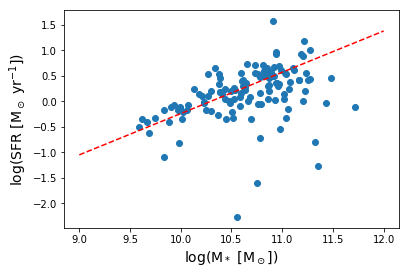

In [8]:
print(db['caMass'].unit,db['caSFR'].unit)
valid_ssfr = (~np.isnan(db['caMass'])) & (~np.isnan(db['caSFR']))
plt.scatter(db['caMass'][valid_ssfr],db['caSFR'][valid_ssfr])
x_ms = np.linspace(9,12,num=50)
y_ms = 0.81*x_ms-8.34
plt.plot(x_ms,y_ms,'r--')
plt.xlabel('log($M_*$ [$M_\odot$])', fontsize=14)
plt.ylabel('log(SFR [$M_\odot$ yr$^{-1}$])', fontsize=14)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Text(0, 0.5, 'log($t_{dep}$ [yr])')

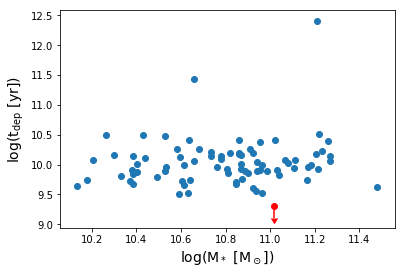

In [9]:
gasmass = molmass*db['coSmooth_natv']*db['caDistMpc']**2
det  = np.where(db['coSmooth_natv']/db['coeSmooth_natv']>=4)[0]
ndet = np.where(db['coSmooth_natv']/db['coeSmooth_natv']<4)[0]
tgaslg = np.log10(gasmass.value/db['caSFR'])
plt.scatter(db['caMass'][det],tgaslg[det])
plt.scatter(db['caMass'][ndet],tgaslg[ndet],color='red')
uplims = np.zeros(db['caMass'][ndet].shape)
uplims[:] = True
plt.errorbar(db['caMass'][ndet],tgaslg[ndet], uplims=uplims, 
             yerr=0.2, ls='none', color='red')
plt.xlabel('log($M_*$ [$M_\odot$])', fontsize=14)
plt.ylabel('log($t_{dep}$ [yr])', fontsize=14)

Text(0.5, 0, 'log($M(H_2)$ [$M_\\odot$])')

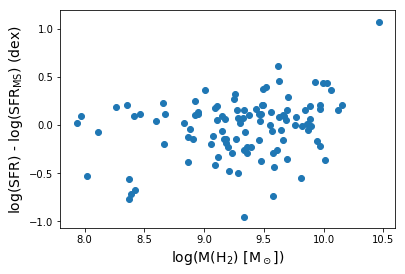

In [10]:
delsfr = db['caSFR'] - (0.81*db['caMass']-8.34)
valid_mgas = (~np.isnan(db['caMass'])) & (~np.isnan(db['caSFR'])) & (~np.isnan(db['coSmooth_natv']))
mgas = np.log10(1.05e4*db['caDistMpc']**2*db['coSmooth_natv'])
plt.scatter(mgas[valid_mgas], delsfr[valid_mgas])
plt.ylabel(r'log(SFR) - log(SFR$_{\rm MS}$) (dex)', fontsize=14)
plt.xlabel('log($M(H_2)$ [$M_\odot$])', fontsize=14)

Text(0.5, 0, 'log($M(H_2)/M_*$)')

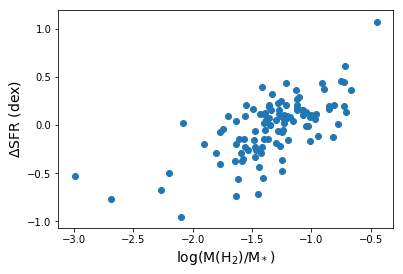

In [11]:
fgas = mgas - db['caMass']
plt.scatter(fgas[valid_mgas], delsfr[valid_mgas])
plt.ylabel('$\Delta$SFR (dex)', fontsize=14)
plt.xlabel('log($M(H_2)/M_*$)', fontsize=14)